In [67]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import kurtosis, skew, pearsonr
from skimage.color import rgb2gray
from sklearn import preprocessing

# split data
from sklearn.model_selection import train_test_split

# Models

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# XGBoost
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb

# SVM 
from sklearn.svm import SVC
from sklearn import svm


## YCbCr Chroma 
We get the chrominance channels and then get the kurtosis of each channel.
These values can behave attypical on AI images, showing low kurtosis than real images.
However, exploring with a few images, I noticed that some AI images follow this pattern, while others not.

In [31]:
def calculate_ycbcr_chrominance_kurtosis(image_path):
    """
    Calculates the Fisher kurtosis of the Cb and Cr chrominance channels 
    of an image.
    """
    # 1. Read the image
    img_bgr = cv2.imread(image_path)

    # 2. Convert the image to YCrCb (OpenCV uses YCrCb, not YCbCr)
    # The channels in the resulting array will be Y, Cr, Cb.
    # Note: OpenCV's convention is BGR and YCrCb.
    img_ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    
    # 3. Extract the Cr and Cb channels
    # Channel 0 is Y (Luminance)
    # Channel 1 is Cr (Red-difference chrominance)
    # Channel 2 is Cb (Blue-difference chrominance)
    
    # We are interested in Cb (index 2) and Cr (index 1)
    Y, cr_channel, cb_channel = cv2.split(img_ycrcb)
    
    # Reshape the 2D channel arrays into 1D for kurtosis calculation
    cb_data = cb_channel.ravel()
    cr_data = cr_channel.ravel()
    
    kurtosis_cb = kurtosis(cb_data)
    kurtosis_cr = kurtosis(cr_data)
    
    return kurtosis_cb, kurtosis_cr

In [32]:
print('Kurtosis Cb AI image ', calculate_ycbcr_chrominance_kurtosis('imagenet_midjourney/test/ai/39_midjourney_34.png'))
print('Kurtosis Cr Real Image ', calculate_ycbcr_chrominance_kurtosis('imagenet_midjourney/test/nature/ILSVRC2012_val_00000634.JPEG'))

Kurtosis Cb AI image  (np.float64(-0.36192062260120705), np.float64(-1.2480978607942883))
Kurtosis Cr Real Image  (np.float64(1.0340358001263619), np.float64(11.935706833326927))


## Chroma Residuals

Using a laplacian filter, we can find patters to distiguish between AI images and real images.
In this case, we get the residual value, which is a distribution. We get the kurtosis from the distribution.
Commonly IA images have a lower kurtosis than real images

In [33]:
def calculate_laplacian_residual_kurtosis(image_path):
    """
    Calculates the Fisher kurtosis of the Cb and Cr chrominance channel residuals 
    after applying a Laplacian filter (which acts as a high-pass filter).
    
    """
    # 1. Read the image
    img_bgr = cv2.imread(image_path)

    # 2. Convert to YCrCb (OpenCV's convention: Y, Cr, Cb)
    img_ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    
    # Extract the Cb and Cr channels
    # Channel 1 is Cr (Red-difference chrominance)
    # Channel 2 is Cb (Blue-difference chrominance)
    cr_channel = img_ycrcb[:, :, 1]
    cb_channel = img_ycrcb[:, :, 2]

    cr_residual = cv2.Laplacian(cr_channel, ddepth=cv2.CV_64F, ksize=3)
    cb_residual = cv2.Laplacian(cb_channel, ddepth=cv2.CV_64F, ksize=3)
    
    # 4. Compute Kurtosis of the Residuals
    
    # Flatten the 2D residual arrays into 1D for kurtosis calculation
    cr_data = cr_residual.ravel()
    cb_data = cb_residual.ravel()
    
    # Calculate Fisher's Excess Kurtosis. 
    # Kurtosis of noise is often high (leptokurtic) due to heavy tails.
    kurtosis_cr_residual = kurtosis(cr_data)
    kurtosis_cb_residual = kurtosis(cb_data)
    
    return kurtosis_cr_residual, kurtosis_cb_residual

In [34]:
print('Kurtosis Cb with laplacian filter for an AI image ', calculate_laplacian_residual_kurtosis('imagenet_midjourney/test/ai/39_midjourney_34.png'))
print('Kurtosis Cr with laplacian filter for a Real Image ', calculate_laplacian_residual_kurtosis('imagenet_midjourney/test/nature/ILSVRC2012_val_00000634.JPEG'))

Kurtosis Cb with laplacian filter for an AI image  (np.float64(1.0884449770995488), np.float64(1.238487633165665))
Kurtosis Cr with laplacian filter for a Real Image  (np.float64(35.15310299959203), np.float64(24.076687132543896))


## RGB correlation
We get the RGB values to check the correlation between them.
Usually the values from AI images are not correlated as real images.
We can see this as well displaying the histogram of the RGB as is seen in the following image:

Note: if you want to show the plot, you need to send an show_plot = 1


In [35]:
def calculate_rgb_inter_channel_correlation(image_path, show_plot = 0):
    """
    Calculates the Pearson correlation coefficients between the R, G, and B 
    channels of an image.
    
    """
    img_bgr = cv2.imread(image_path)

    # 2. Split and Flatten the Channels
    # Split the image into its B, G, R components
    b_channel, g_channel, r_channel = cv2.split(img_bgr)
    
    # Flatten the 2D arrays (H x W) into 1D vectors (H*W)
    # This prepares the data for standard statistical correlation
    r_flat = r_channel.ravel()
    g_flat = g_channel.ravel()
    b_flat = b_channel.ravel()

    if show_plot:
        plt.hist(r_channel.flatten(), bins=25, color='red')
        plt.title('Histogram - Red')
        plt.grid()
        plt.show()
    
        plt.hist(g_channel.flatten(), bins=25, color='green')
        plt.title('Histogram - green')
        plt.grid()
        plt.show()
    
    
        plt.hist(b_channel.flatten(), bins=25, color='blue')
        plt.title('Histogram - blue')
        plt.grid()
        plt.show()
        
    # 3. Combine the flattened channels into a single array for np.corrcoef
    # The array should have shape (3, N), where N is the total number of pixels.
    data_matrix = np.stack([r_flat, g_flat, b_flat], axis=0)


    correlation_matrix = np.corrcoef(data_matrix)
    correlation_coefficient, p_value = pearsonr(r_flat, g_flat)

    
    r_g_corr = correlation_matrix[0, 1]  # Correlation between R and G
    r_b_corr = correlation_matrix[0, 2]  # Correlation between R and B
    g_b_corr = correlation_matrix[1, 2]  # Correlation between G and B

    return r_g_corr, r_b_corr, g_b_corr


AI image, does not have a normal distribution


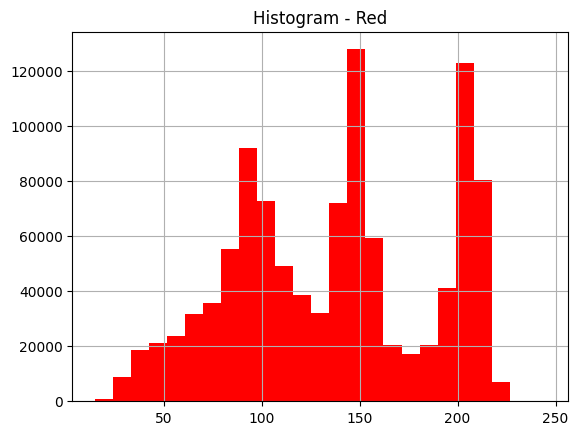

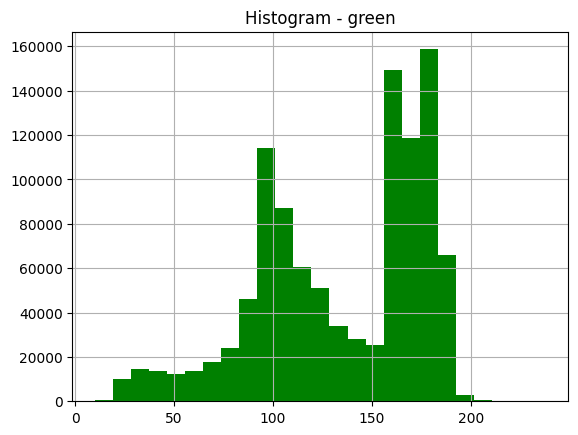

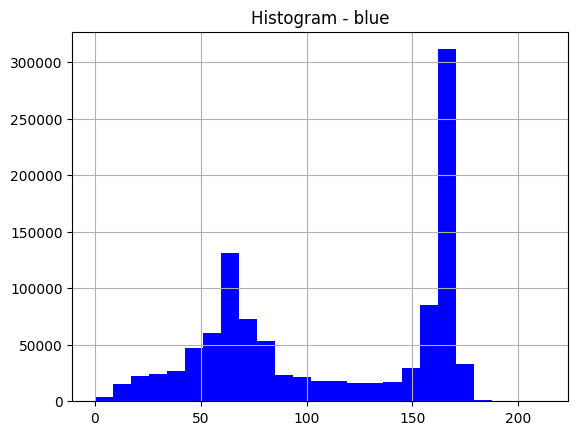

Real Image, has something similar a normal distribution 


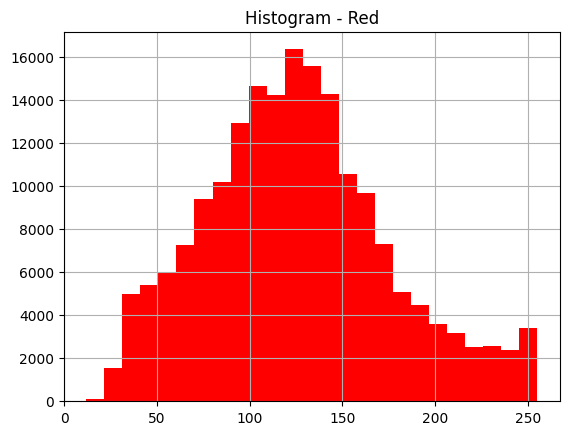

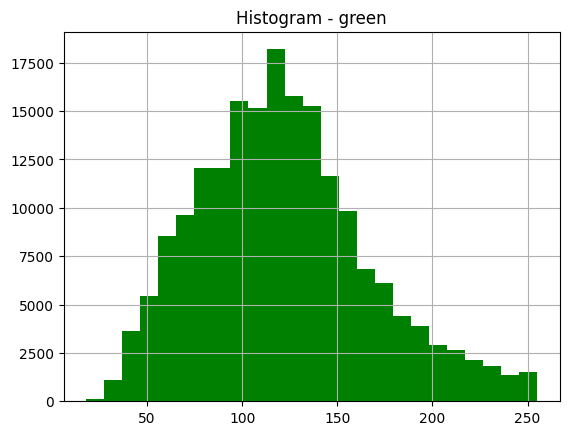

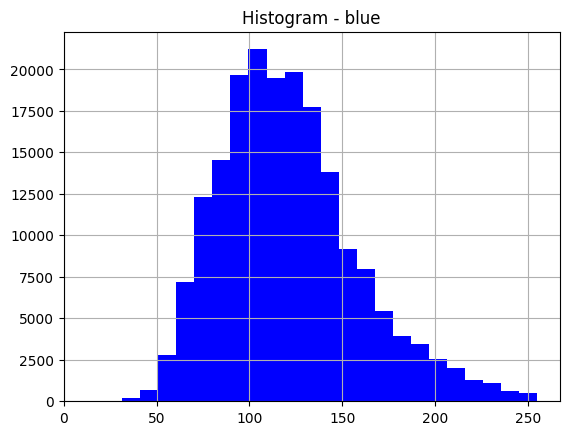

(np.float64(0.9862702606247001),
 np.float64(0.8958326287367445),
 np.float64(0.9378513736594868))

In [36]:
print('AI image, does not have a normal distribution')
calculate_rgb_inter_channel_correlation('imagenet_midjourney/test/ai/39_midjourney_34.png', show_plot=1)
print('Real Image, has something similar a normal distribution ')
calculate_rgb_inter_channel_correlation('imagenet_midjourney/test/nature/ILSVRC2012_val_00000301.JPEG', show_plot=1)

## Kurtosis and Skew of RGB

As said before, the RBG channels can show a normal distribution in real images than in AI images.
Kurtosis and sckew property can give more detail of these distributions. These features are useful 
to recognise the images


In [37]:
def calculate_rgb_kurtosis_and_sckew(image_path):
    """
    Calculates the kurtosis and skew of the R, G, and B 
    channels of an image.
    
    """
    # 1. Read the image
    # OpenCV reads images in BGR format by default
    img_bgr = cv2.imread(image_path)
    b_channel, g_channel, r_channel = cv2.split(img_bgr)
        
    r_flat = r_channel.ravel()
    g_flat = g_channel.ravel()
    b_flat = b_channel.ravel()
    
    r_kurtosis = kurtosis(r_flat) 
    g_kurtosis = kurtosis(g_flat)
    b_kurtosis = kurtosis(b_flat)

    r_skew = skew(r_flat)
    g_skew = skew(g_flat)
    b_skew = skew(b_flat)

    return r_kurtosis, g_kurtosis, b_kurtosis, r_skew, g_skew, b_skew

In [38]:
print('AI image ', calculate_rgb_kurtosis_and_sckew('imagenet_midjourney/test/ai/39_midjourney_34.png'))

print('Real Image ', calculate_rgb_kurtosis_and_sckew('imagenet_midjourney/test/nature/ILSVRC2012_val_00000301.JPEG'))


AI image  (np.float64(-1.0282456003384026), np.float64(-0.6266833023005898), np.float64(-1.54413378330951), np.float64(-0.043085115159591944), np.float64(-0.5786945201539994), np.float64(-0.19364190365243364))
Real Image  (np.float64(-0.12849335875416257), np.float64(0.03938413144363828), np.float64(0.4945323390292664), np.float64(0.3863433175208686), np.float64(0.5131025227216862), np.float64(0.7170307401879993))


## Spectral Flatness

Here we can inspect the Spectrum Flatness. Usually in the middle are the high frequencies and the low frequencies are away the center. That should be the normal Sprectrum of an image. On the other hand, AI images have a completly different distribution.
The best way to analise it is using Spectral Flatness, which indicates that a low flatness for real images and high flatness for AI images.


In [39]:
# https://python.plainenglish.io/introduction-to-image-processing-with-python-18fec2d8dff8
def spectral_flatness(spectrum: np.ndarray):
    def geometric_mean(x):
        if np.any(x == 0):
            return 0.0
        return np.exp(np.mean(np.log(x)))

    ps = np.abs(spectrum) ** 2
    return geometric_mean(ps) / np.mean(ps)
    
def get_spectrum(image_path, show_plot = 0):
    image = cv2.imread(image_path)
    
    gray_image = rgb2gray(image)
    f_image = np.fft.fft2(gray_image)
    
    fshift = np.fft.fftshift(f_image)
    
    magnitude_spectrum = np.log(np.abs(fshift))
    spectrum = spectral_flatness(magnitude_spectrum)
    
    if show_plot:        
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum')
        plt.axis('off')
        plt.show()
        
    return spectrum


AI image


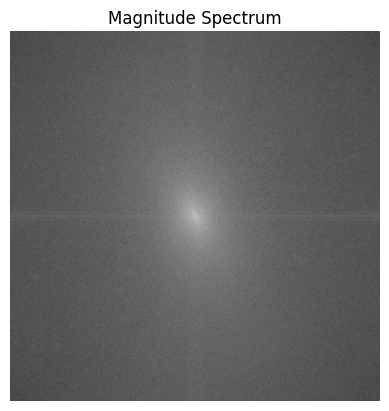

0.805960314726873
Real Image


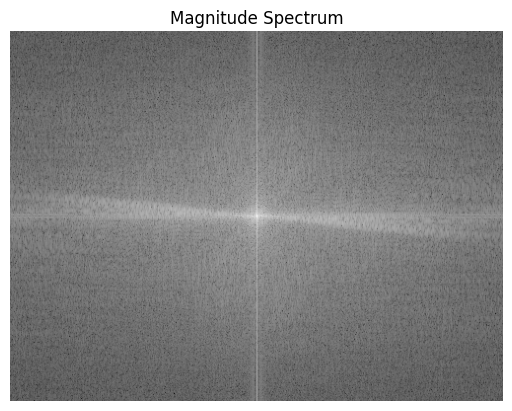

0.3926757865096275


In [40]:
print('AI image')
s = get_spectrum('imagenet_midjourney/test/ai/139_midjourney_34.png', show_plot=1)
print(s)
print('Real Image')
s = get_spectrum('imagenet_midjourney/test/nature/ILSVRC2012_val_00002005.JPEG', show_plot=1)
print(s)

## Mean Intensity and Edge Intensity
Mean Intesity checks the average brightness of an images

Edge Intensity checks concentration of a sharp edges or boundaries of an image


In [41]:
def get_mean_intensity_and_edge_intensity(image_path):
    """
    Returns (mean_intensity, edge_density) for a single image.
    - mean_intensity: average grayscale intensity [0..255]
    - edge_density: proportion of edge pixels using Sobel magnitude threshold
    """
    # Load as RGB then convert to grayscale (uint8)
    img = Image.open(image_path).convert("RGB")
    gray = np.array(img.convert("L"))  # shape (H, W), dtype uint8

    # Feature 1: mean intensity
    mean_intensity = float(gray.mean())

    # Feature 2: edge density using Sobel magnitude
    # Use OpenCV Sobel on float32 normalized [0..1] to get good gradient scale
    gray_f = gray.astype(np.float32) / 255.0
    gx = cv2.Sobel(gray_f, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    gy = cv2.Sobel(gray_f, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    mag = np.sqrt(gx**2 + gy**2)

    # Simple threshold at 0.2 (tune as you like)
    thresh = 0.2
    edges = (mag > thresh).astype(np.uint8)
    edge_density = float(edges.mean())  # fraction of edge pixels

    return mean_intensity, edge_density


In [42]:
print('AI image ', get_mean_intensity_and_edge_intensity('imagenet_midjourney/test/ai/139_midjourney_34.png'))

print('Real Image ', get_mean_intensity_and_edge_intensity('imagenet_midjourney/test/nature/ILSVRC2012_val_00002005.JPEG'))


AI image  (121.8028736114502, 0.4563779830932617)
Real Image  (103.38722133333333, 0.13644266666666666)


## Contrast, Homogeneity, Energy and correlation
Real Images

Higher contrast (richer fine texture and edges)

Higher energy (more structured pixel pair distributions)

Higher homogeneity (natural local smoothness amid structured variation)

AI Image

Lower contrast (smoother transitions, less micro-detail)

Lower energy (flatter texture uniformity)

Nearly equal correlation (generative models capture large-scale dependencies well, but not fine-scale randomness)

In [46]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def compute_glcm_features(image_path):
    # 1. Read the image and convert to grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # 2. Quantize: reduce grayscale levels (0–63)
    img = (img / 4).astype(np.uint8)  # 256/4 = 64 levels
    
    # 3. Compute GLCM for multiple distances and angles
    distances = [1, 2, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(img, 
                        distances=distances, 
                        angles=angles, 
                        levels=64, 
                        symmetric=True, 
                        normed=True)
    
    # 4. Extract properties
    features = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean()
    }
    
    return features


In [47]:
print('AI image ', compute_glcm_features('imagenet_midjourney/test/ai/139_midjourney_34.png'))

print('Real Image ', compute_glcm_features('imagenet_midjourney/test/nature/ILSVRC2012_val_00002005.JPEG'))

AI image  {'contrast': np.float64(30.182466993042336), 'homogeneity': np.float64(0.347323483834362), 'energy': np.float64(0.046838580760323774), 'correlation': np.float64(0.9190158651600533)}
Real Image  {'contrast': np.float64(44.62124222709411), 'homogeneity': np.float64(0.6090468950813153), 'energy': np.float64(0.0983973827270817), 'correlation': np.float64(0.9230556315730386)}


In [ ]:
rows = []
for folder, label in [("imagenet_midjourney/test/ai", 1), ("imagenet_midjourney/test/nature", 0)]:
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        if not os.path.isfile(path): 
            continue
            
        mean_intensity, edge_intensity = get_mean_intensity_and_edge_intensity(path)
        kurtosis_cb, kurtosis_cr = calculate_ycbcr_chrominance_kurtosis(path)
        kurtosis_cr_residual, kurtosis_cb_residual = calculate_laplacian_residual_kurtosis(path)
        r_g_corr, r_b_corr, g_b_corr = calculate_rgb_inter_channel_correlation(path)
        r_kurtosis, g_kurtosis, b_kurtosis, r_skew, g_skew, b_skew = calculate_rgb_kurtosis_and_sckew(path)
        spectrum_flatness = get_spectrum(path) 
        glcm_features = compute_glcm_features(path)
        rows.append({
            "file_path": path,
            "mean_intensity": mean_intensity,
            "edge_density": edge_intensity,
            "spectrum_flatness" : spectrum_flatness,
            "r_kurtosis": r_kurtosis,
            "g_kurtosis": g_kurtosis,
            "b_kurtosis": b_kurtosis,
            "r_skew": r_skew,
            "g_skew": g_skew,
            "b_skew": b_skew,
            "r_g_corr": r_g_corr,
            "r_b_corr": r_b_corr,
            "g_b_corr": g_b_corr,
            "kurtosis_cr_residual": kurtosis_cr_residual,
            "kurtosis_cb_residual": kurtosis_cb_residual,
            "kurtosis_cb": kurtosis_cb,
            "kurtosis_cr": kurtosis_cr,            
            "contrast": glcm_features['contrast'],
            "homogeneity": glcm_features['homogeneity'],
            "energy": glcm_features['energy'],
            "correlation": glcm_features['correlation'],
            "label": label
        })

df = pd.DataFrame(rows)
df.to_csv('features_images.csv', index=False)

/var/folders/c5/kvs4zf7x2sl0k1z2fdtkxl5h0000gn/T/ipykernel_28928/575276133.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis_cb = kurtosis(cb_data)
/var/folders/c5/kvs4zf7x2sl0k1z2fdtkxl5h0000gn/T/ipykernel_28928/575276133.py:27: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis_cr = kurtosis(cr_data)


In [68]:
# We can skip the above cell, in case we have the feature in a csv

df = pd.read_csv('features_images.csv')

# Preparing Data

Here we separate the data between 

features = X

label = y

In [69]:
X = df.drop(['label', 'file_path'], axis=1) # Features
y = df['label'] # Target

In [70]:
X

,mean_intensity,edge_density,spectrum_flatness,r_kurtosis,g_kurtosis,b_kurtosis,r_skew,g_skew,b_skew,r_g_corr,r_b_corr,g_b_corr,kurtosis_cr_residual,kurtosis_cb_residual,kurtosis_cb,kurtosis_cr,contrast,homogeneity,energy,correlation
0,117.090787,0.161981,0.333780,-1.127755,-0.956213,-0.834478,-0.000841,0.340065,0.583515,0.842543,0.607587,0.917658,2.531067,2.793006,-0.607025,0.148531,13.024068,0.641801,0.089413,0.977793
1,66.074798,0.146701,0.825935,0.044632,0.062334,0.032893,0.943361,0.951317,0.939376,0.999961,0.999954,0.999940,0.455845,8.801154,5.700131,-0.495998,20.908730,0.619278,0.151984,0.958638
2,170.313185,0.022654,0.359850,-0.589852,-0.499418,-0.933069,-0.426347,-0.541021,-0.395986,0.971984,0.919173,0.983215,2.324420,2.956710,-0.068263,-0.228240,1.528955,0.854919,0.141354,0.996443
3,89.795885,0.213519,0.225965,-0.676220,-0.002694,1.064305,0.253491,0.502331,1.132086,0.813153,0.788791,0.814246,0.607857,0.913915,0.413666,-0.701424,12.563476,0.595598,0.092999,0.964042
4,109.457084,0.291970,0.602762,-1.192001,-0.983584,-0.647029,0.113744,0.330212,0.638316,0.964528,0.877581,0.966933,22.135910,38.354430,1.076538,3.380314,31.017740,0.491110,0.054815,0.947413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,186.963665,0.096384,0.625383,0.956857,0.625452,0.866677,-1.446542,-1.312883,-1.384354,0.998407,0.998964,0.999497,15.736582,14.799665,0.444295,-1.118251,28.137745,0.792891,0.165064,0.957669
996,121.042464,0.214816,0.623614,-0.231864,-0.877756,-1.378061,-0.493278,-0.103903,-0.129693,0.886512,0.845178,0.922395,1.535850,0.965760,-0.399458,-0.843093,15.839488,0.504433,0.075327,0.911761
997,124.374005,0.228579,0.490304,-1.247139,-1.216559,-1.092762,-0.105638,0.006985,-0.095163,0.987688,0.947262,0.972914,103.394087,69.706880,6.336707,10.313181,36.872142,0.559237,0.074677,0.951261
998,157.713980,0.241051,0.665653,-0.549031,-1.102855,-1.170849,-0.923623,-0.725973,-0.733164,0.926960,0.903440,0.976565,7.907482,7.584777,1.749331,3.788984,19.582654,0.578749,0.099867,0.970818


In [71]:
y.head

<bound method NDFrame.head of 0      1
1      1
2      1
3      1
4      1
      ..
995    0
996    0
997    0
998    0
999    0
Name: label, Length: 1000, dtype: int64>

# Slicing Data for training and Data Normalisation

Here we use the simple rule 

80% for training

20% for testing

but we have another split,

which is 

60% for training

40% for testing

In [72]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [73]:
def get_dataset_splitted(size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=size, random_state=42
    )

    return X_train, X_test, y_train, y_test

In [74]:
def show_confunsion_matrix(model, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    # Create the display object directly from the estimator (model) and data
    disp = ConfusionMatrixDisplay.from_estimator(
        model,             # The trained model (classifier)
        X_test,          # The test features
        y_test,          # The true labels
        display_labels=model.classes_,
        cmap=plt.cm.Blues, # Color map to use
        normalize=None     # 'None' for counts, 'true', 'pred', or 'all' for normalization
    )
    
    # Display the plot
    disp.plot()


In [75]:
def show_classification_report(model, X_test, y_test, y_pred):
    print(classification_report(y_test, y_pred))

# Random Forest Classifier

Basically decision trees to classify the images based on the features.
Each desicion tree is an expert, therefore it is able to identify in this case based on a feature if the image
is real of AI generated. 
Each decision tree work together to classify the image

In [76]:
X_train, X_test, y_train, y_test = get_dataset_splitted()

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [77]:
show_classification_report(rf, X_test, y_test, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       104
           1       0.89      0.90      0.89        96

    accuracy                           0.90       200
   macro avg       0.89      0.90      0.89       200
weighted avg       0.90      0.90      0.90       200



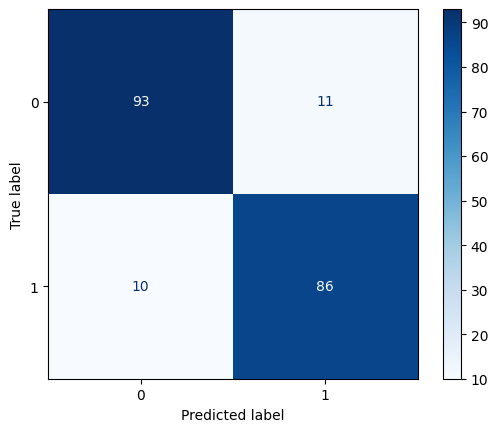

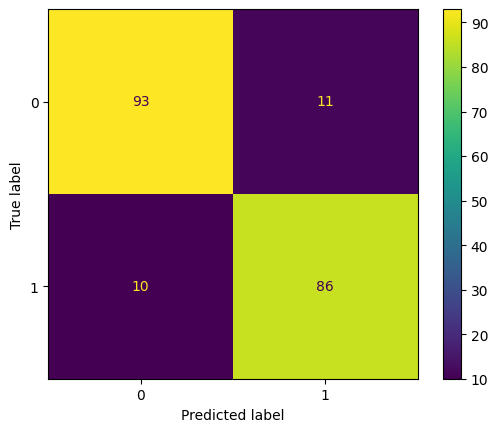

In [78]:
show_confunsion_matrix(rf, y_test, y_pred)

In [99]:
X_train, X_test, y_train, y_test = get_dataset_splitted(0.4)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       192
           1       0.91      0.87      0.89       208

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.88       400
weighted avg       0.89      0.89      0.89       400



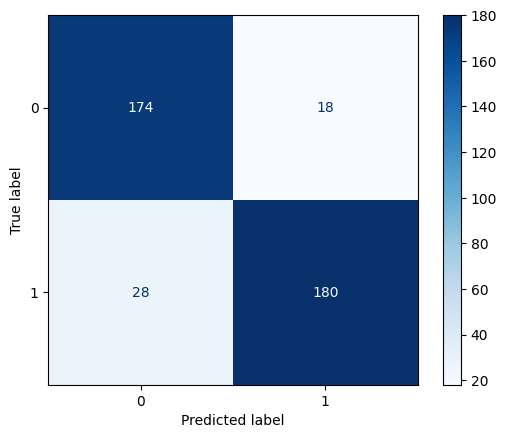

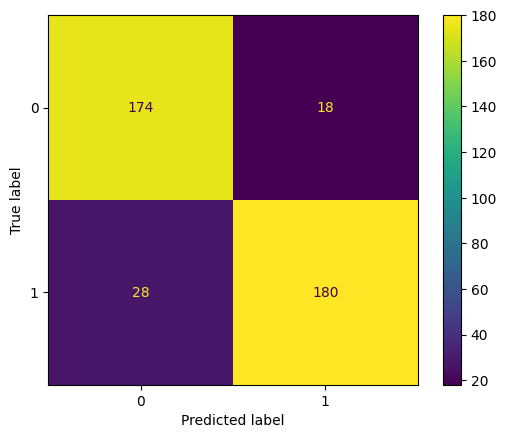

In [100]:
show_classification_report(rf, X_test, y_test, y_pred)
show_confunsion_matrix(rf, y_test, y_pred)

In [80]:
X_train, X_test, y_train, y_test = get_dataset_splitted()

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

grid_predictions = CV_rfc.predict(X_test) 

{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}


              precision    recall  f1-score   support

           0       0.90      0.90      0.90       104
           1       0.90      0.90      0.90        96

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



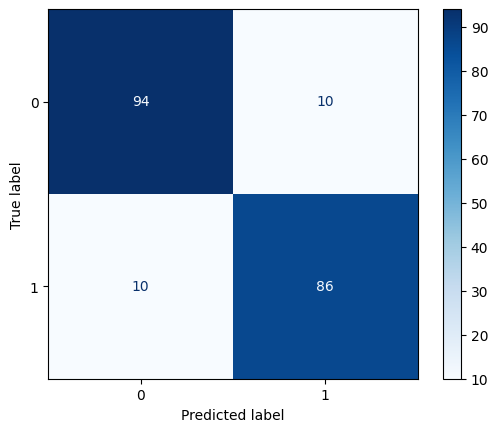

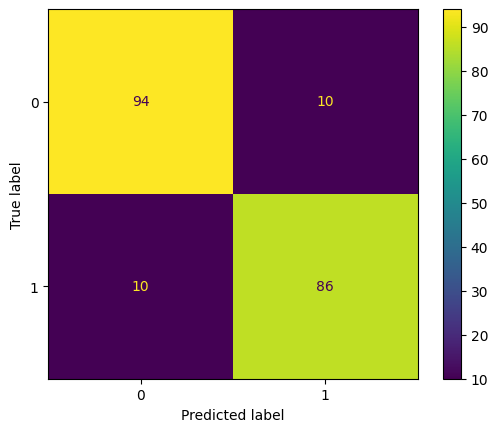

In [81]:
show_classification_report(CV_rfc, X_test, y_test, grid_predictions)
show_confunsion_matrix(CV_rfc, y_test, grid_predictions)

# XGB Classifier
Models that is really good in performance.

It tries to make a first prediction comparing the prediction from the real answer(residuals).
it iterates creating weak decision trees to improve the prediction. it uses gradient descent algorithm to 
minimise loss and therefore, be efficient

At the end, it used a logistic regression based on a threshold to calcula the final result.


In [82]:
X_train, X_test, y_train, y_test = get_dataset_splitted()

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc", early_stopping_rounds=5)


xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)

accuracy_score(y_test, y_pred)

[0]	validation_0-auc:0.91892
[1]	validation_0-auc:0.92768
[2]	validation_0-auc:0.94596
[3]	validation_0-auc:0.94922
[4]	validation_0-auc:0.95633
[5]	validation_0-auc:0.96134
[6]	validation_0-auc:0.96785
[7]	validation_0-auc:0.97175
[8]	validation_0-auc:0.97035
[9]	validation_0-auc:0.96995
[10]	validation_0-auc:0.97135
[11]	validation_0-auc:0.97075
[12]	validation_0-auc:0.97075


0.895

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       104
           1       0.88      0.91      0.89        96

    accuracy                           0.90       200
   macro avg       0.89      0.90      0.89       200
weighted avg       0.90      0.90      0.90       200



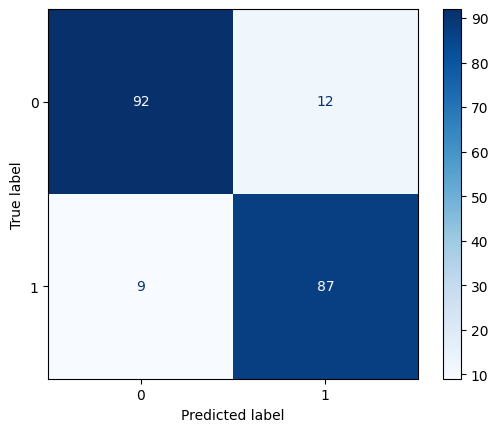

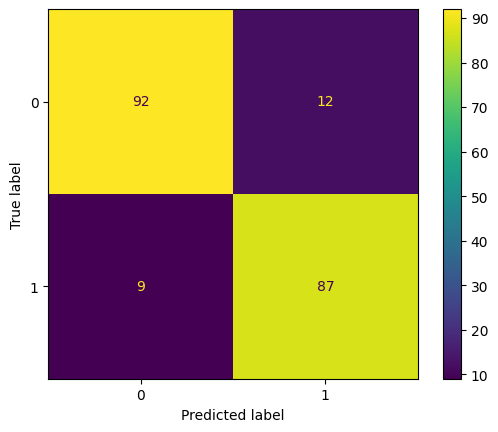

In [83]:
show_classification_report(xgb_model, X_test, y_test, y_pred)
show_confunsion_matrix(xgb_model, y_test, y_pred)

In [84]:
X_train, X_test, y_train, y_test = get_dataset_splitted(0.4)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc", early_stopping_rounds=5)


xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_pred = xgb_model.predict(X_test)

accuracy_score(y_test, y_pred)

[0]	validation_0-auc:0.91207
[1]	validation_0-auc:0.92071
[2]	validation_0-auc:0.92916
[3]	validation_0-auc:0.94086
[4]	validation_0-auc:0.94308
[5]	validation_0-auc:0.95052
[6]	validation_0-auc:0.95674
[7]	validation_0-auc:0.95751
[8]	validation_0-auc:0.95783
[9]	validation_0-auc:0.95940
[10]	validation_0-auc:0.95812
[11]	validation_0-auc:0.95957
[12]	validation_0-auc:0.95896
[13]	validation_0-auc:0.95791
[14]	validation_0-auc:0.95838
[15]	validation_0-auc:0.95961
[16]	validation_0-auc:0.96069
[17]	validation_0-auc:0.95991
[18]	validation_0-auc:0.96084
[19]	validation_0-auc:0.96176
[20]	validation_0-auc:0.96141
[21]	validation_0-auc:0.96209
[22]	validation_0-auc:0.96299
[23]	validation_0-auc:0.96284
[24]	validation_0-auc:0.96267
[25]	validation_0-auc:0.96219
[26]	validation_0-auc:0.96289
[27]	validation_0-auc:0.96334
[28]	validation_0-auc:0.96422
[29]	validation_0-auc:0.96392
[30]	validation_0-auc:0.96412
[31]	validation_0-auc:0.96402
[32]	validation_0-auc:0.96454
[33]	validation_0-au

0.8975

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       192
           1       0.93      0.87      0.90       208

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



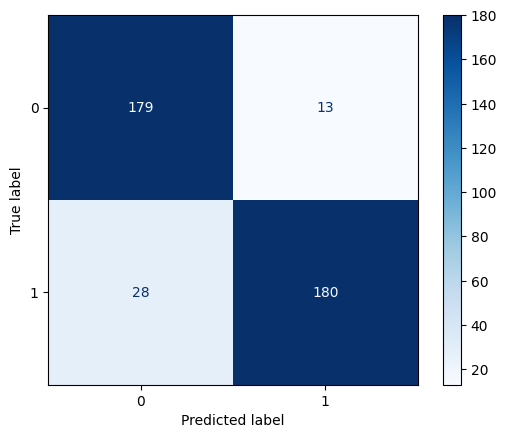

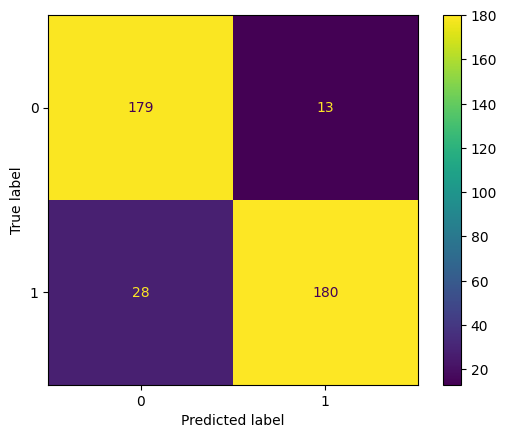

In [85]:
show_classification_report(xgb_model, X_test, y_test, y_pred)
show_confunsion_matrix(xgb_model, y_test, y_pred)

In [87]:
X_train, X_test, y_train, y_test = get_dataset_splitted()

param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Create XGBoost classifier
xgb_grid = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_grid, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print best parameters
print(f"Best parameters: {grid_search.best_params_}")

grid_predictions = grid_search.predict(X_test) 

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=3, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=3, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=5, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=5, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_weight=1, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, min_child_weight=3, subsample=0.6; total time= 

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       104
           1       0.91      0.92      0.91        96

    accuracy                           0.92       200
   macro avg       0.91      0.92      0.91       200
weighted avg       0.92      0.92      0.92       200



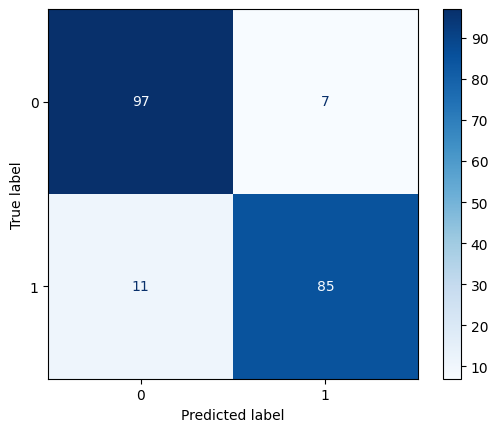

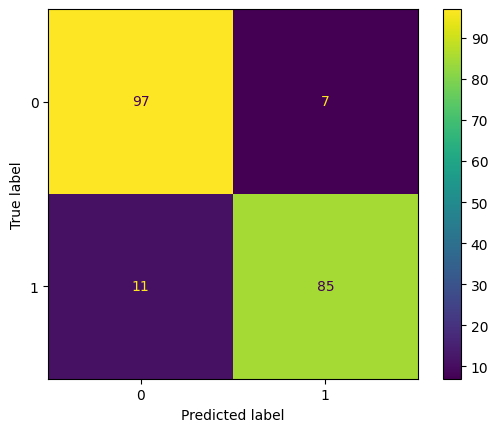

In [88]:
show_classification_report(grid_search, X_test, y_test, grid_predictions)
show_confunsion_matrix(xgb_model, y_test, grid_predictions)

# SVM Linear Kernel

SVM is a vector that supports to separte the data. Therefore, it is useful for classification tasks.

In this case, we have a multi-dimensional set of features. It's not possible to display a plot but
the model tries to separate them.


In [89]:
# remove None values
X_ds = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X_ds, y, test_size=0.2, random_state=42
)

In [90]:
C = 1
gamma = 0.01
clf = SVC(kernel="linear", C=C, gamma=gamma)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       104
           1       0.80      0.88      0.84        96

    accuracy                           0.83       200
   macro avg       0.84      0.84      0.83       200
weighted avg       0.84      0.83      0.83       200



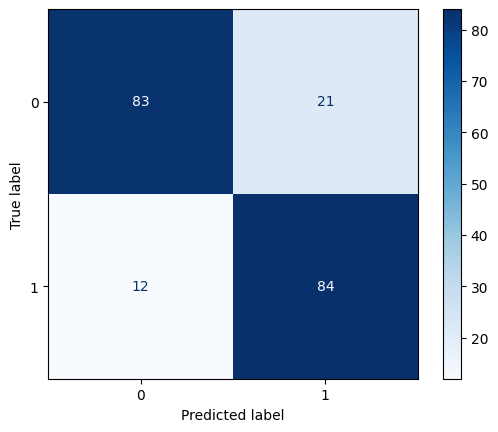

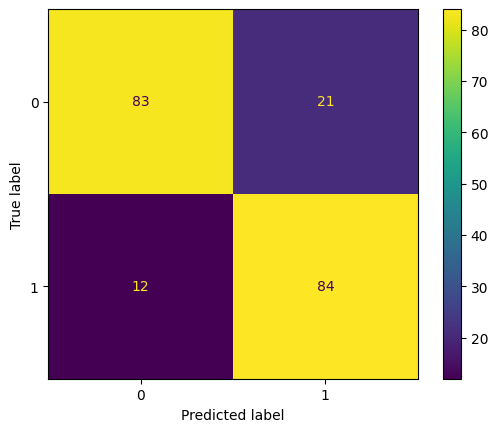

In [91]:
show_classification_report(clf, X_test, y_test, y_pred)
show_confunsion_matrix(clf, y_test, y_pred)

In [104]:
# remove None values
X_ds = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X_ds, y, test_size=0.3, random_state=42
)

In [105]:
clf = SVC(kernel="linear")

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       150
           1       0.83      0.87      0.85       150

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300



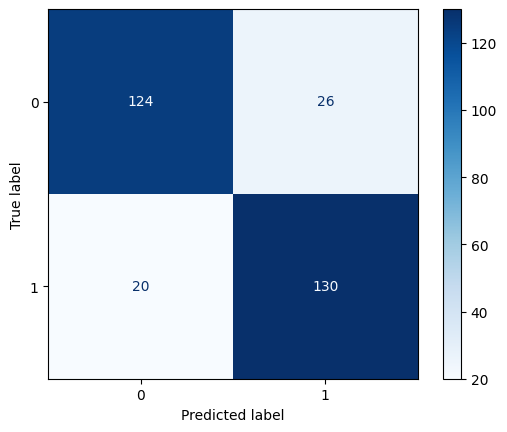

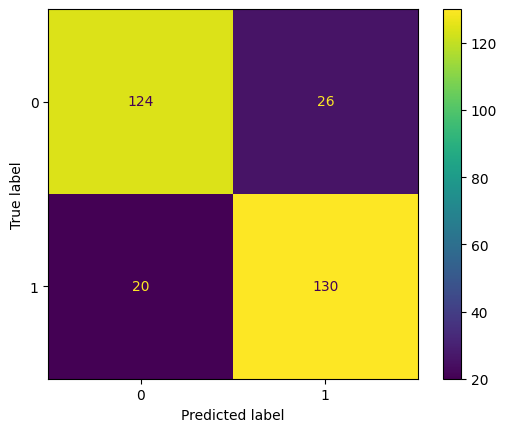

In [106]:
show_classification_report(clf, X_test, y_test, y_pred)
show_confunsion_matrix(clf, y_test, y_pred)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ds, y, test_size=0.3, random_state=42
)

param_grid = {'C': [0.1, 1], 
            'gamma': [1, 0.1, 0.01], 
            'kernel': ['linear']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
 
grid.fit(X_train, y_train)
print(grid.best_params_) 
 
print(grid.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.793 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.857 total time=   0.1s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.814 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.771 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.800 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.793 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.857 total time=   0.0s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.814 total time=   0.0s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.771 total time=   0.0s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.800 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.793 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear;,

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       150
           1       0.83      0.87      0.85       150

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300



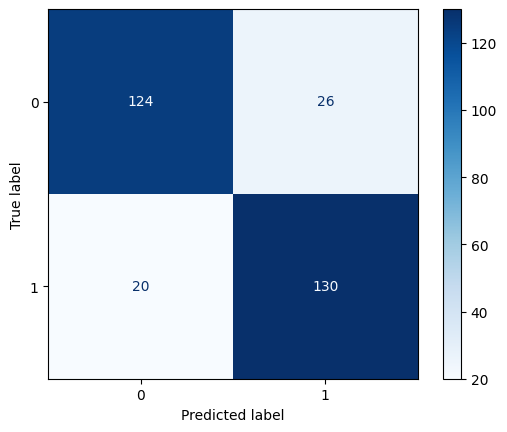

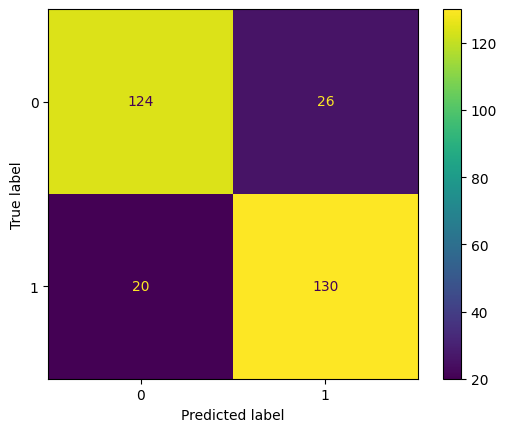

In [111]:
grid_predictions = grid.predict(X_test) 
show_classification_report(grid, X_test, y_test, grid_predictions)
show_confunsion_matrix(grid, y_test, grid_predictions)

References

https://www.investopedia.com/terms/k/kurtosis.asp

https://saturncloud.io/blog/how-to-compute-row-average-in-pandas/#:~:text=The%20simplest%20way%20to%20compute,be%20either%20rows%20or%20columns.

https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis

https://www.quarkml.com/2022/10/the-rbf-kernel-in-svm-complete-guide.html

https://pub.aimind.so/unlocking-the-power-of-rbf-kernel-advantages-local-boundaries-gammas-influence-2aebafce336a

https://scikit-learn.org/stable/modules/preprocessing.html

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

https://www.datacamp.com/tutorial/random-forests-classifier-python

https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html

https://how.dev/answers/how-to-implement-crossvalpredict-in-sklearn

https://xgboosting.com/grid-search-xgboost-hyperparameters/

https://www.kaggle.com/code/usamabajwa86/classification-report

https://www.mygreatlearning.com/blog/gridsearchcv/
